In [64]:
import fsl
from nilearn.maskers import NiftiLabelsMasker
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import load_img
from nilearn.plotting import view_img
import os
import spm12
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import dicom2nifti
import SimpleITK as sitk
import nibabel as nib
import copy

data_dir = "data"


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



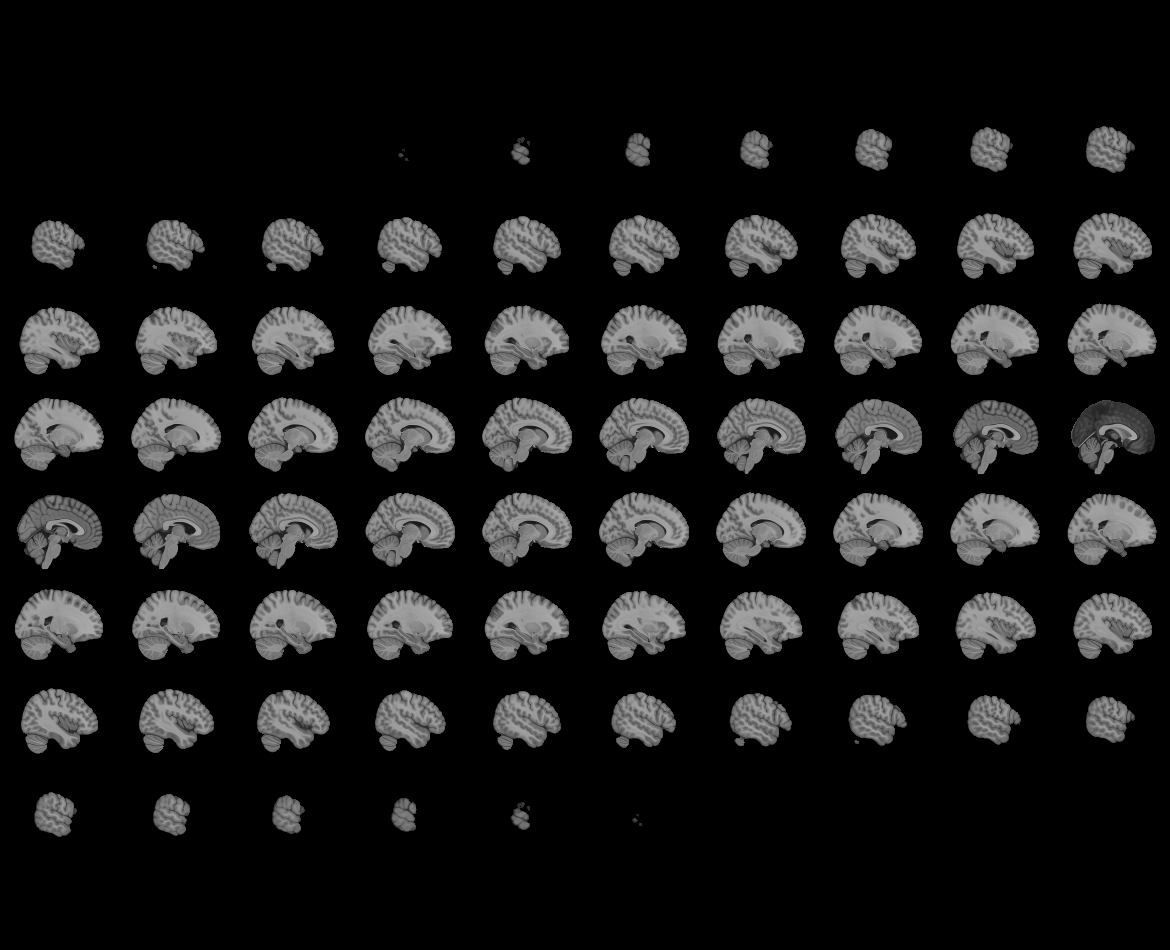
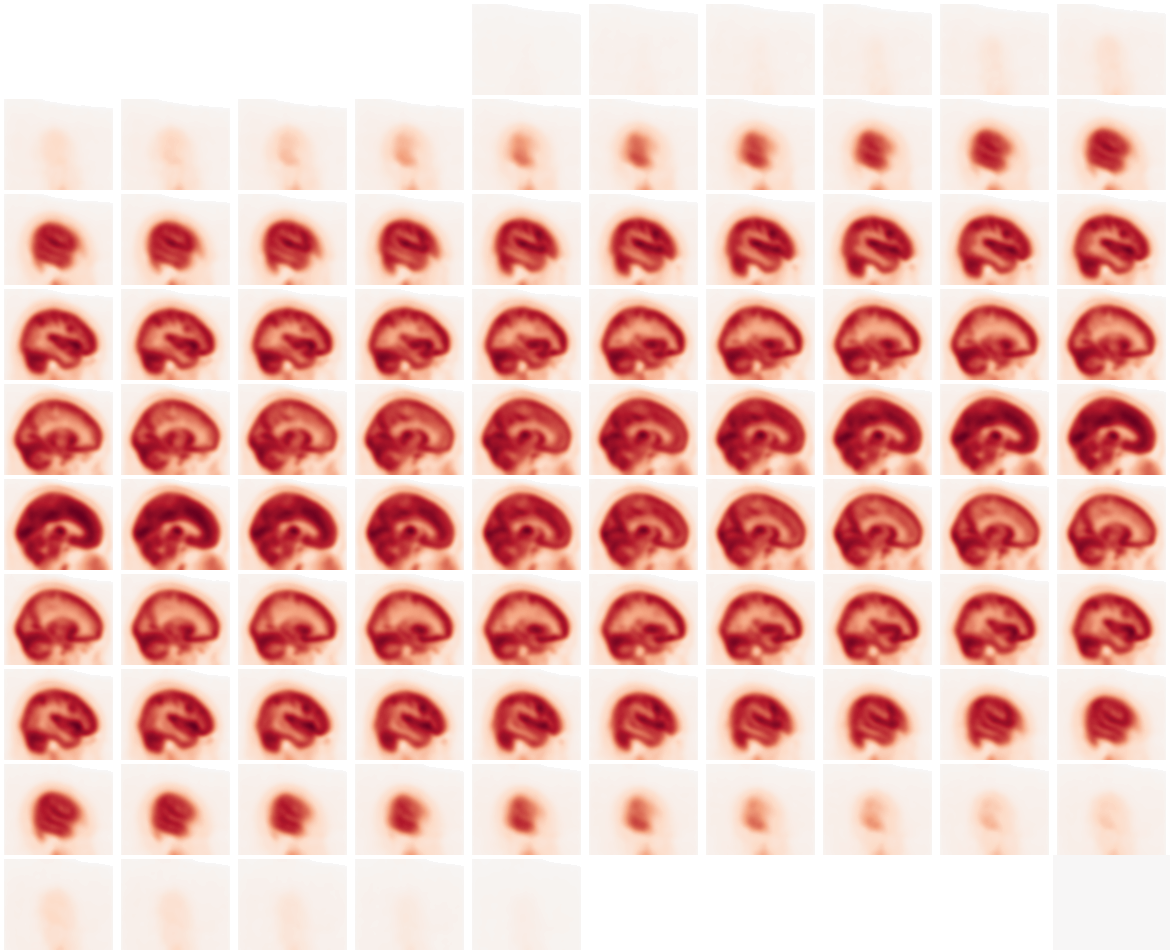

In [ ]:
fdg_pet_template = load_img(os.path.join(data_dir,'PET.nii'))
view_img(fdg_pet_template)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\huw\AppData\Local\Temp\ipykernel_40940\2394332167.py:2: UserWarning: Casting data from int32 to float32
  view_img(spect_template)



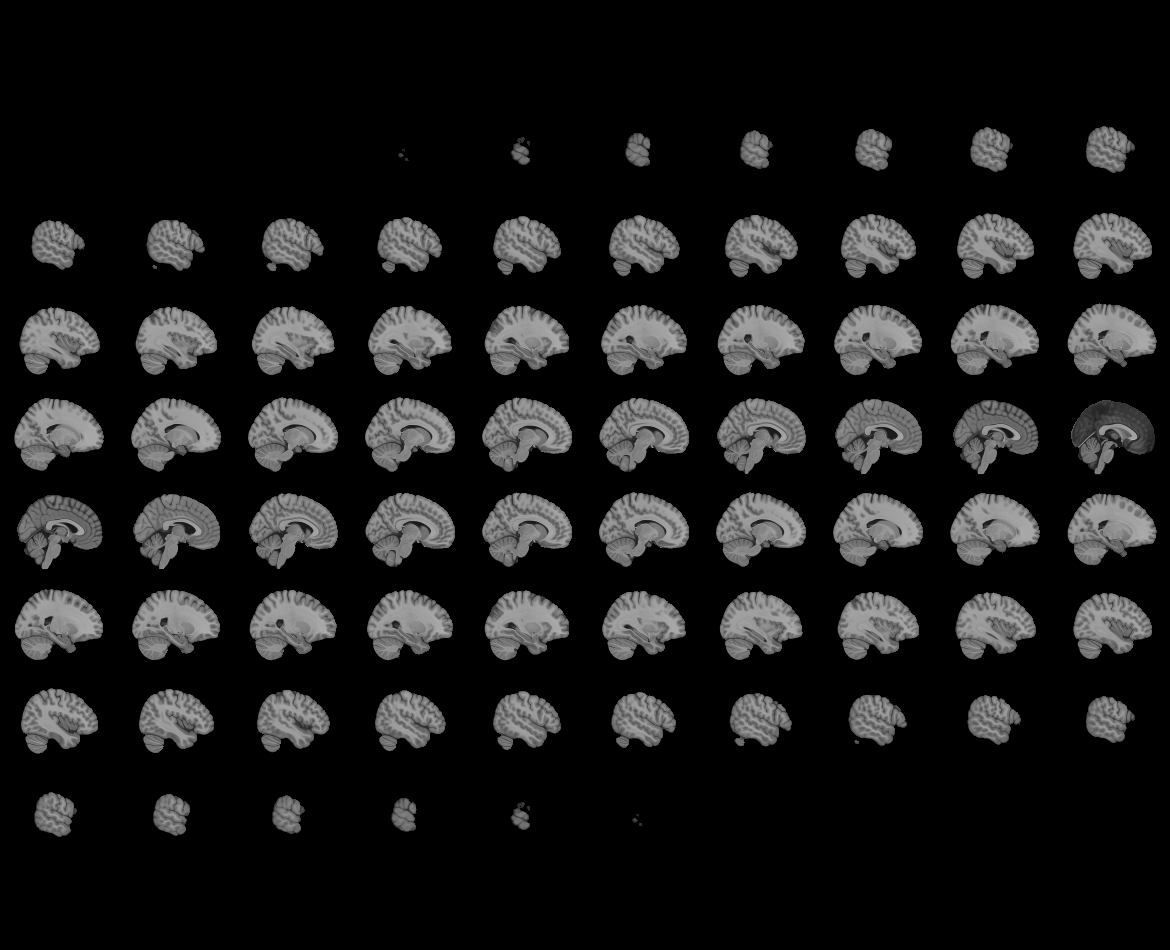
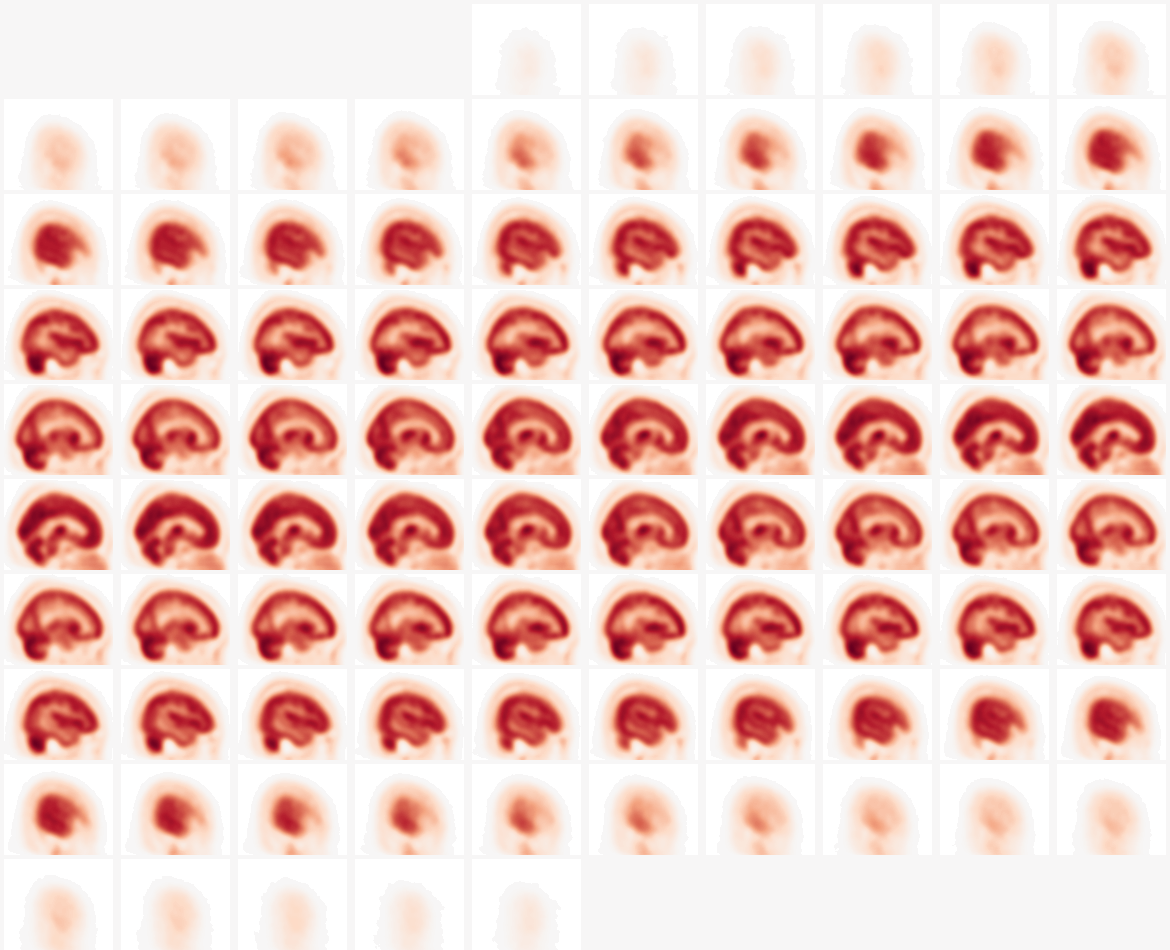

In [3]:
spect_template = load_img(os.path.join(data_dir, 'SPECT.nii'))
view_img(spect_template)

In [ ]:
spect_dir = os.path.join(data_dir, 'phantom_spect')
nifti_dir = os.path.join(data_dir, 'phantom_spect_nifti')

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(spect_dir)
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()
sitk.WriteImage(image, os.path.join(nifti_dir, 'phantom_spect_new.nii'))

file = nib.load(os.path.join(nifti_dir, 'phantom_spect_new.nii'))


('data\\phantom_spect/phantom_new_sitk.dcm',)


In [96]:
spect_dir = os.path.join(data_dir, 'phantom_spect/phantom_new_1.dcm')
nifti_dir = os.path.join(data_dir, 'phantom_spect_nifti/phantom_new_1.nii')

image = sitk.ReadImage(spect_dir)
sitk.WriteImage(image, nifti_dir)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



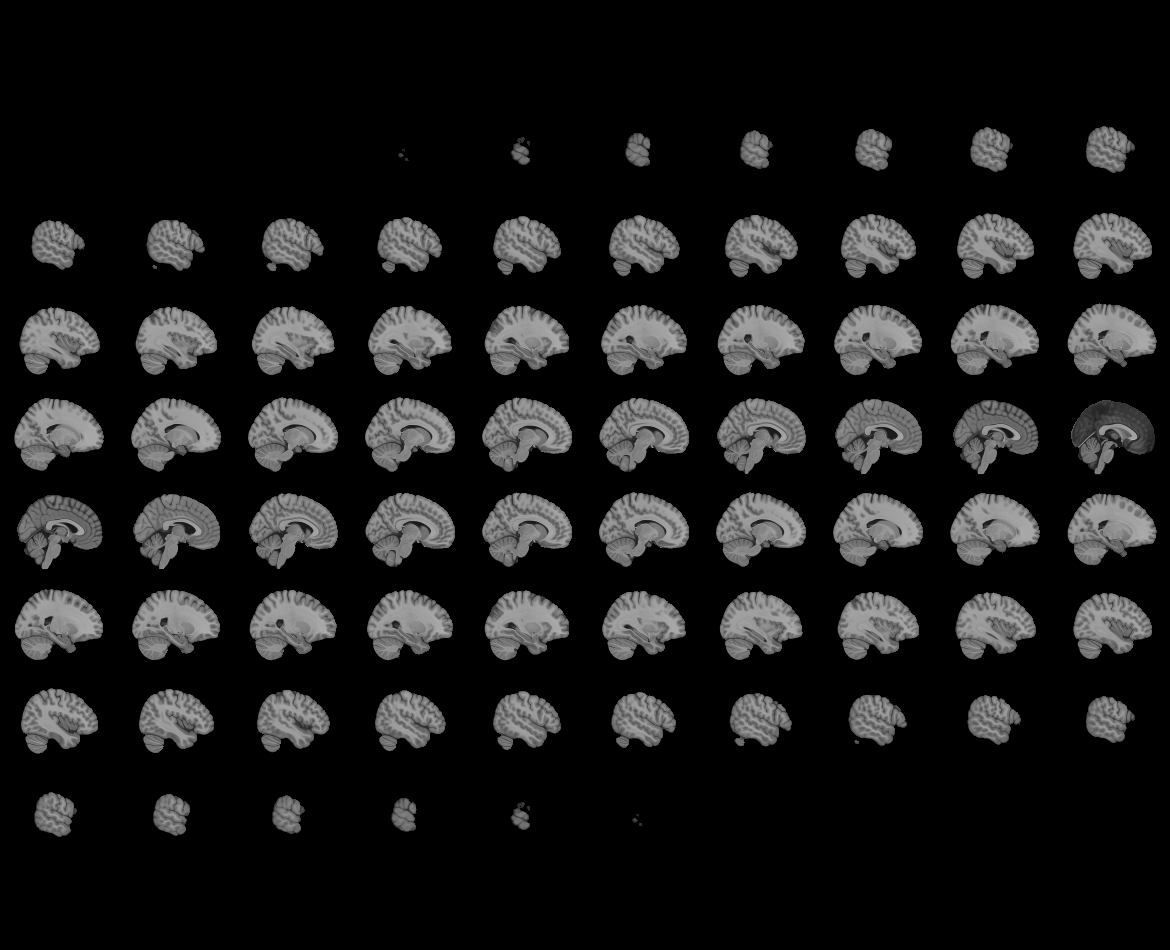
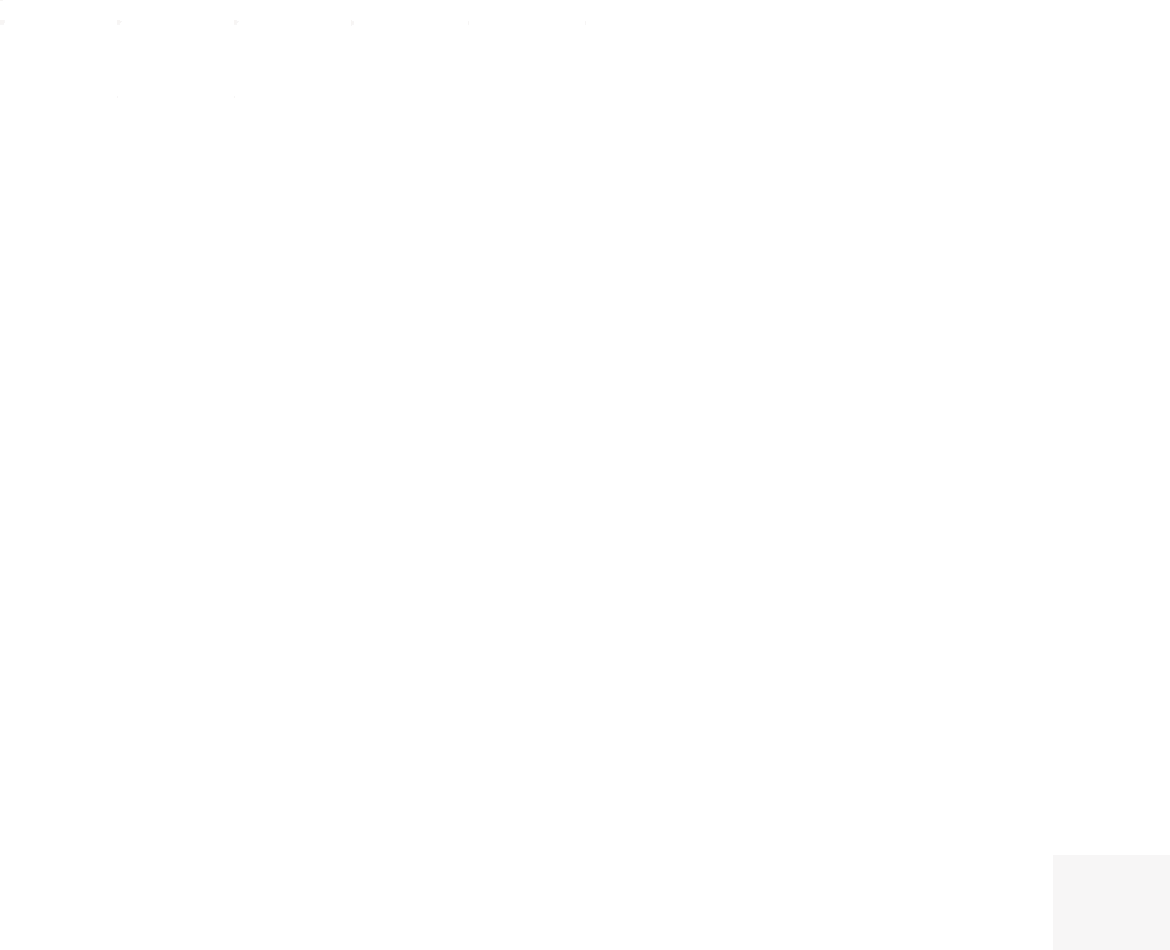

In [97]:
spect_template = load_img(os.path.join(data_dir, 'phantom_spect_nifti/phantom_new_1.nii'))
view_img(spect_template)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



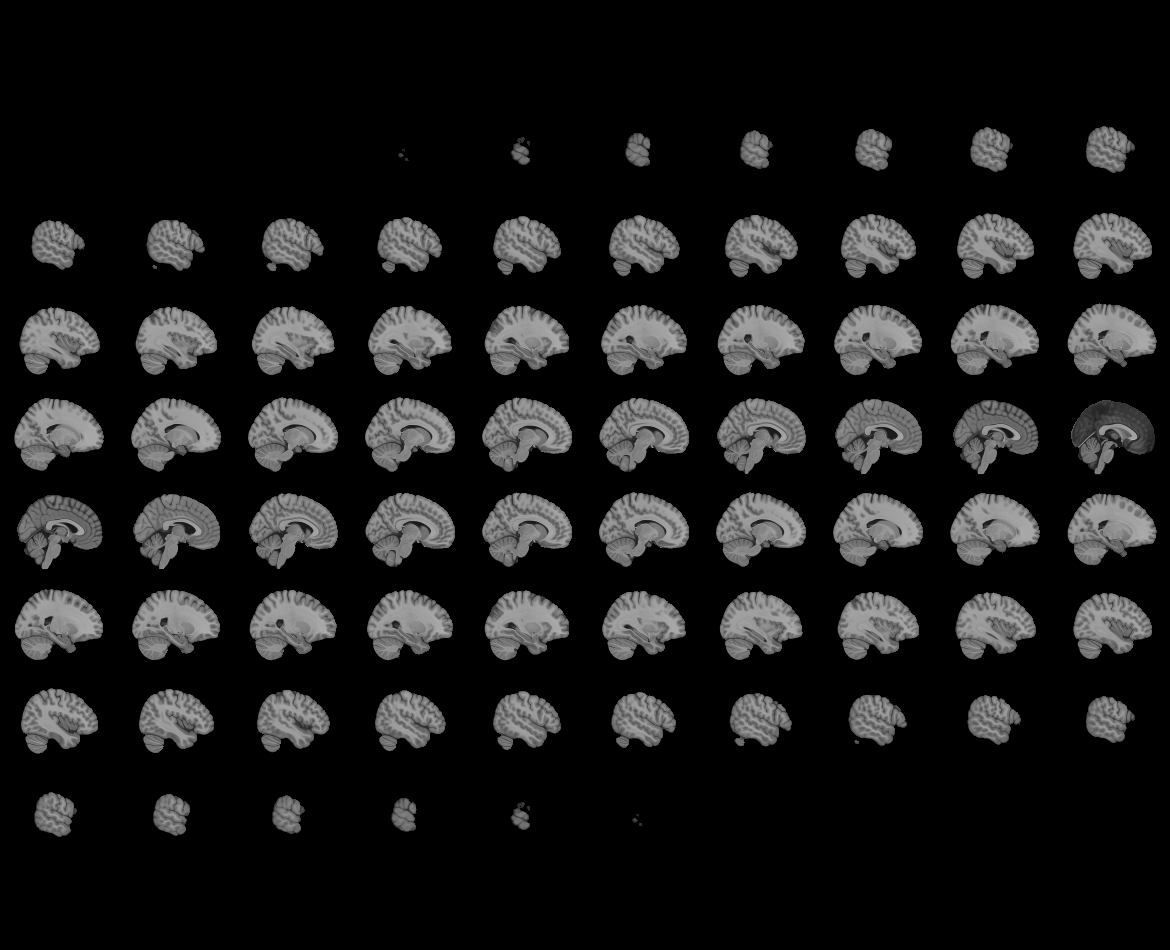
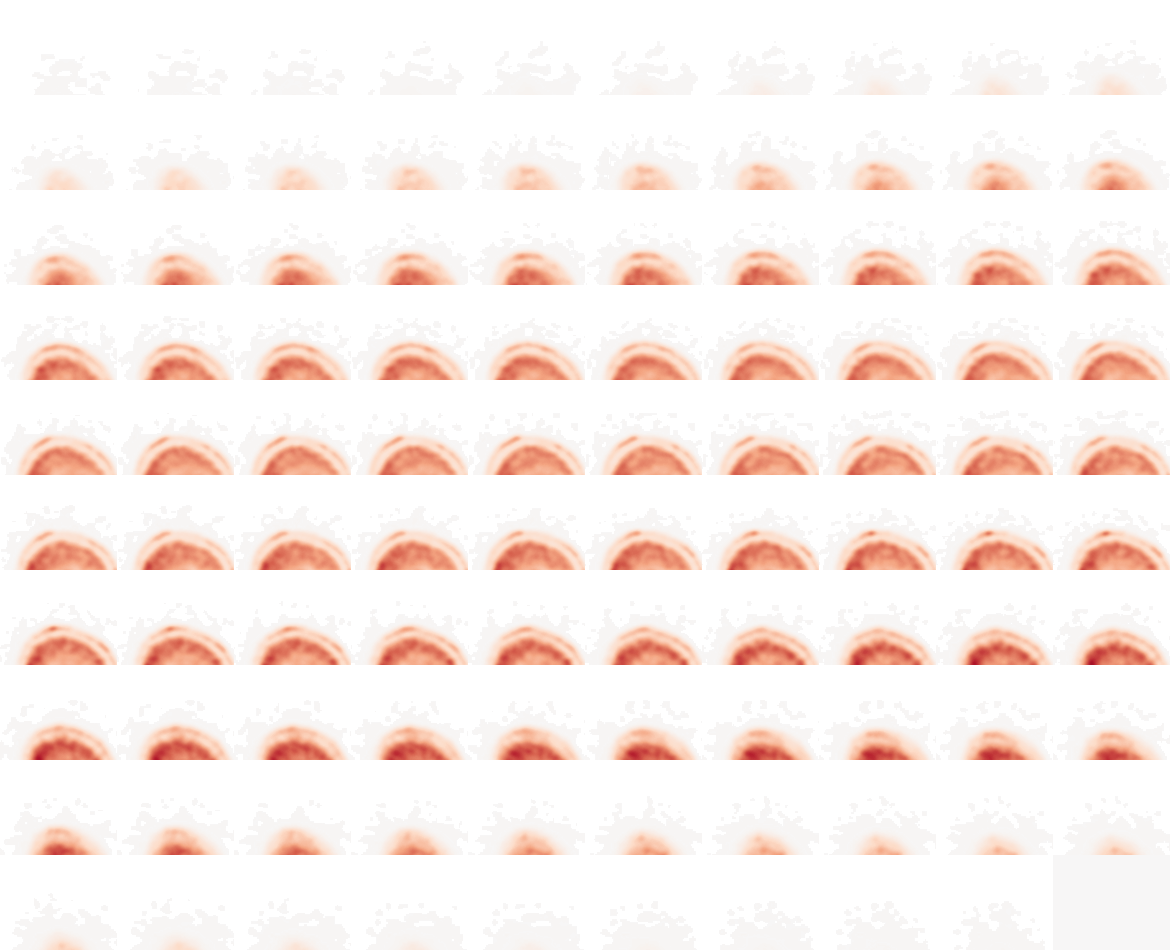

In [80]:
spect_template = load_img(os.path.join(data_dir, 'phantom_spect_nifti/NEW_phantom.nii'))
view_img(spect_template)

### Recenter the SPECT Phantom image as a DICOM

In [ ]:
spect_phantom_dicom_path = os.path.join(data_dir, "phantom_spect/phantom.dcm")

In [60]:
image = pydicom.dcmread(spect_phantom_dicom_path)
print(image)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 100
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.12.2.1107.5.9.20000101
(0002,0013) Implementation Version Name         SH: 'SIEMENS_SWFSYNGO'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'RECON TOMO', 'EMISSION']
(0008,0016) SOP Class UID                       UI: Nuclear Medicine Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.6.1.1009.32300118052510031828100000079
(0008,0020) Study Date                          DA: '20180525'
(0008,0021) Series Date                         DA: '20180525'
(0008,0022) Acquisition Date                    DA: '20180525'
(0008,

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (74) exceeds the maximum length of 64 allowed for VR LO.
  warn_and_log(msg)


In [61]:

image_pos = image[0x0054, 0x0022][0][0x0020, 0x0032].value
image_orientation = image[0x0054, 0x0022][0][0x0020, 0x0037].value
pixel_spacing = image[0x0028, 0x0030].value
window_center = image[0x0028,0x1050].value
print(image_pos)
print(image_orientation)
print(pixel_spacing)
print(window_center)

[-210.65241568532, -369.03986142166, -34.188960856046]
[0.9999859955322, -0.005251900896, -0.000652898503, 0.00525633980851, 0.99996172742519, 0.00699389567072]
[3.2956700325012, 3.2956700325012]
60


In [62]:
# Convert extracted values to numpy arrays
ImagePositionPatient = np.array(image_pos, dtype=np.float64)
ImageOrientationPatient = np.array(image_orientation, dtype=np.float64)
VoxelSize = np.array(pixel_spacing, dtype=np.float64)

# Create transformation matrix
MatPosOrientation = np.zeros((4, 4), dtype=np.float64)
MatPosOrientation[3, 3] = 1
MatPosOrientation[0:3, 0] = ImageOrientationPatient[0:3] * VoxelSize[0]
MatPosOrientation[0:3, 1] = ImageOrientationPatient[3:6] * VoxelSize[1]
MatPosOrientation[0:3, 3] = ImagePositionPatient

# Prepare coordinate indices
IndCol = np.zeros((4, 1), dtype=np.float64)
CenterRow = image.Rows / 2
CenterCol = image.Columns / 2

# Center position
IndCol[:, 0] = [CenterCol, CenterRow, 0, 1]
CenterImagePosition = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

# Corners
IndCol[:, 0] = [0, 0, 0, 1]
TopLeft = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

IndCol[:, 0] = [image.Columns - 1, image.Rows - 1, 0, 1]
BottomRight = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

IndCol[:, 0] = [0, image.Rows - 1, 0, 1]
BottomLeft = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

IndCol[:, 0] = [image.Columns - 1, 0, 0, 1]
TopRight = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

# Store results
SpatialInfo = []
SpatialInfo.append({
    'CenterImagePosition': CenterImagePosition,
    'TopLeft': TopLeft,
    'BottomRight': BottomRight,
    'BottomLeft': BottomLeft,
    'TopRight': TopRight
})

In [63]:
SpatialInfo

[{'CenterImagePosition': array([   1.37619487, -159.23279798,  -32.85149946]),
  'TopLeft': array([-210.65241569, -369.03986142,  -34.18896086]),
  'BottomRight': array([210.09185839,  47.2960301 , -31.53493589]),
  'BottomLeft': array([-208.45237416,   49.49421372,  -31.26166516]),
  'TopRight': array([ 207.89181687, -371.23804504,  -34.46223159])}]

In [93]:
spect_phantom_dicom_path = os.path.join(data_dir, "phantom_spect/phantom.dcm")
output_path = os.path.join(data_dir, "phantom_spect/phantom_new_1.dcm")

# Load and deepcopy original DICOM
image = pydicom.dcmread(spect_phantom_dicom_path)
image_copy = copy.deepcopy(image)

# Extract nested values
image_pos = image[0x0054, 0x0022][0][0x0020, 0x0032].value  # ImagePositionPatient (top-left voxel)
image_orientation = image[0x0054, 0x0022][0][0x0020, 0x0037].value  # ImageOrientationPatient
pixel_spacing = image[0x0028, 0x0030].value  # PixelSpacing
slice_thickness = float(image.SliceThickness)  # Assume SliceThickness present

# Convert to numpy arrays
ImagePositionPatient = np.array(image_pos, dtype=np.float64)
ImageOrientationPatient = np.array(image_orientation, dtype=np.float64)
VoxelSize = np.array(pixel_spacing, dtype=np.float64)

# Calculate slice direction vector as cross product of row and column orientation vectors
row_dir = ImageOrientationPatient[0:3]
col_dir = ImageOrientationPatient[3:6]
slice_dir = np.cross(row_dir, col_dir)

# Build the 4x4 spatial matrix (voxel index to physical coordinate)
MatPosOrientation = np.zeros((4, 4), dtype=np.float64)
MatPosOrientation[3, 3] = 1
MatPosOrientation[0:3, 0] = row_dir * VoxelSize[0]       # row direction vector scaled
MatPosOrientation[0:3, 1] = col_dir * VoxelSize[1]       # column direction vector scaled
MatPosOrientation[0:3, 2] = slice_dir * slice_thickness  # slice direction vector scaled
MatPosOrientation[0:3, 3] = ImagePositionPatient         # origin = top-left voxel physical position

# Calculate center voxel index (0-based)
CenterRow = 2
CenterCol = 0
CenterSlice = 16

# Create homogeneous voxel index vector for center voxel (col, row, slice, 1)
IndCol = np.zeros((4, 1), dtype=np.float64)
IndCol[:, 0] = [CenterCol, CenterRow, CenterSlice, 1]

# Compute physical coordinate of center voxel (brain center)
CenterImagePosition = np.dot(MatPosOrientation, IndCol).flatten()[0:3]

# Shift the ImagePositionPatient by center voxel's position to recenter image
new_ImagePositionPatient = ImagePositionPatient - CenterImagePosition

# Update DICOM field for ImagePositionPatient in the sequence
image_copy[0x0054, 0x0022][0][0x0020, 0x0032].value = [2,0,16]

# Save updated DICOM
image_copy.save_as(output_path)
print(f"Saved recentered DICOM as: {output_path}")

Saved recentered DICOM as: data\phantom_spect/phantom_new_1.dcm


In [94]:
spect_phantom_dicom_path = os.path.join(data_dir, "phantom_spect/phantom_new_1.dcm")

image = pydicom.dcmread(spect_phantom_dicom_path)
print(image)

image_pos = image[0x0054, 0x0022][0][0x0020, 0x0032].value
image_orientation = image[0x0054, 0x0022][0][0x0020, 0x0037].value
pixel_spacing = image[0x0028, 0x0030].value
window_center = image[0x0028,0x1050].value
print(image_pos)
print(image_orientation)
print(pixel_spacing)
print(window_center)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 100
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.12.2.1107.5.9.20000101
(0002,0013) Implementation Version Name         SH: 'SIEMENS_SWFSYNGO'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'RECON TOMO', 'EMISSION']
(0008,0016) SOP Class UID                       UI: Nuclear Medicine Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.6.1.1009.32300118052510031828100000079
(0008,0020) Study Date                          DA: '20180525'
(0008,0021) Series Date                         DA: '20180525'
(0008,0022) Acquisition Date                    DA: '20180525'
(0008,